STFTで周波数分布の図を書いて見て，その図から現在注目している音を探し出せるか調べた．

In [53]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from scipy import signal
import IPython.display

In [54]:
fileName = "tone.mp3"

In [55]:
data, samplerate = sf.read(fileName)

print("サンプリング周波数:", samplerate)
print("データ数:", np.shape(data))
print("サンプリング時間:", np.shape(data)[0]/samplerate)

サンプリング周波数: 48000
データ数: (465920,)
サンプリング時間: 9.706666666666667


In [56]:
f, t, Sxx = signal.spectrogram(data, samplerate)

元の音の周波数分布が大体こんな感じ．同じ周波数の音を，４回に分けて鳴らしている．

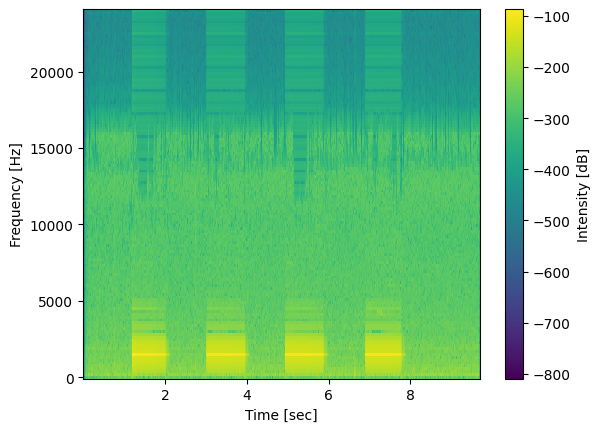

In [57]:
#図の描画
plt.pcolormesh(t, f, 10*np.log(Sxx)) #intensityを修正
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cbar = plt.colorbar() #カラーバー表示のため追加
cbar.ax.set_ylabel("Intensity [dB]") #カラーバーの名称表示のため追加
plt.show()

鳴らしているぴー音だけ抜き出してみる．

In [77]:
tone = data[57000:95000]

In [78]:
IPython.display.Audio(tone, rate=samplerate)

In [79]:
# 前から，周波数，その時間，信号強度の順番
tone_f, tone_t, tone_Sxx = signal.spectrogram(tone, samplerate)

In [ ]:
鳴らしてる時の周波数分布が大体こんな感じ

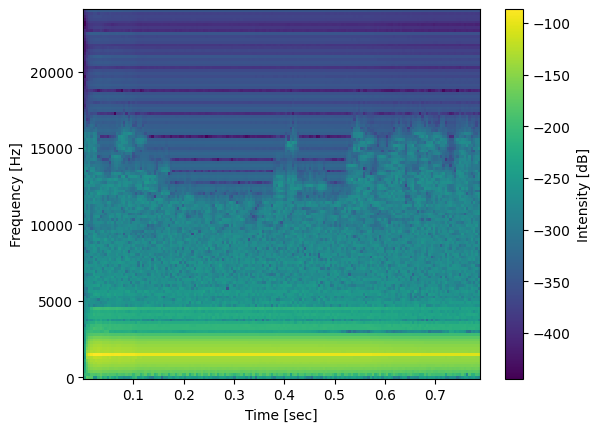

In [80]:
#図の描画
plt.pcolormesh(tone_t, tone_f, 10*np.log(tone_Sxx)) #intensityを修正
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cbar = plt.colorbar() #カラーバー表示のため追加
cbar.ax.set_ylabel("Intensity [dB]") #カラーバーの名称表示のため追加
plt.show()

一番最初の音を，ノイズまみれの環境で収録したやつを開く．

In [63]:
fileName = "tone_withnoise.mp3"
noisedData, samplerate = sf.read(fileName)

print("サンプリング周波数:", samplerate)
print("データ数:", np.shape(data))
print("サンプリング時間:", np.shape(data)[0]/samplerate)

サンプリング周波数: 48000
データ数: (465920,)
サンプリング時間: 9.706666666666667


In [64]:
IPython.display.Audio(noisedData, rate=samplerate)

In [65]:
f, t, Sxx = signal.spectrogram(noisedData, samplerate)

ノイズまみれの音の周波数分布が大体こんな感じ．霞んでいるけど，きっちりバンドが見えている．

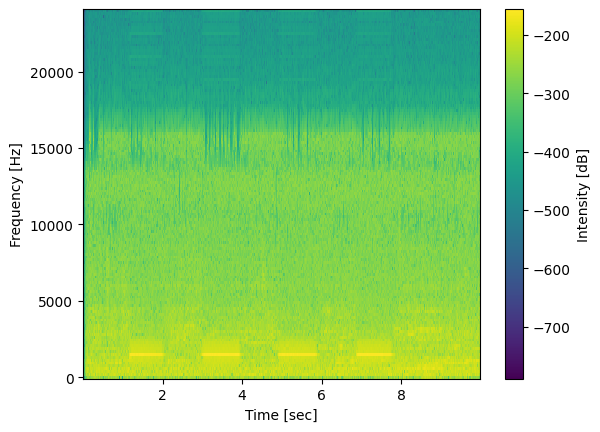

In [66]:
#図の描画
plt.pcolormesh(t, f, 10*np.log(Sxx)) #intensityを修正
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cbar = plt.colorbar() #カラーバー表示のため追加
cbar.ax.set_ylabel("Intensity [dB]") #カラーバーの名称表示のため追加
plt.show()

In [112]:
print("T", np.shape(t))
print("F", np.shape(f))
print("Sxx", np.shape(Sxx))

T (2139,)
F (129,)
Sxx (129, 2139)


Tには，Tが何秒である時であったかが入っている．Fには，そのインデックスに対応するFが幾つであるかが記録されている．なのでまずはFを揃えてやる必要がある．←かと思ったけど，STFTのパラメータが同じだから，Fは既に揃っている．なので次は，Sxxについて無限に引き算しまくって，その差がそれなりに小さくなるところを探す．

とりあえず適当に，ノイズまみれの音の周波数分布から，ピーの音の周波数分布をずらしながら引いてみる．

In [136]:
# データを無限に切り出す．1ずつずらして，探してるデータと同じ幅で切り出す．
for i in range(0, np.shape(t)[0] - np.shape(tone_t)[0]):
    cropped_data = Sxx[:, i: i +  np.shape(tone_t)[0]]
    # 生のストリームのうち，切り出した部分と教師部分の差を求める．
    diff = np.abs(cropped_data - tone_Sxx)

一番最後のサンプルについて，求めた差分を表示してみる．
→うお〜外れていると，確かに一筋の線が見えとるな．これは当然そうで，ノイズまみれの音の周波数分布においてバンドがないのに，ピーの音の周波数分布を引いたから．

じゃあ，この筋が見えている方向でsumを取ってみて一つの配列にして，その配列における分散とかを見ればいいんじゃねえの？ということでやってみる．

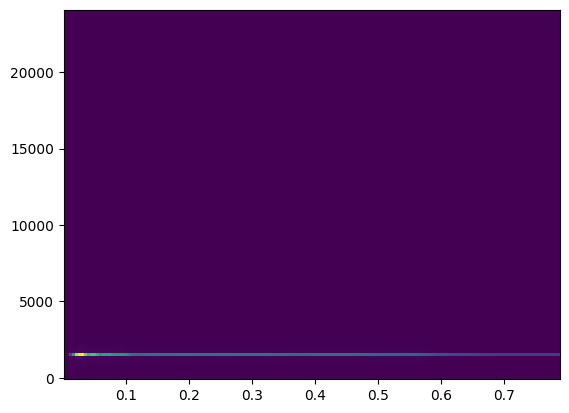

In [138]:
plt.pcolormesh(tone_t, tone_f, diff)

In [180]:
# データ同士を重ねて見やすくするために，頭に無をたす．
zeroarr = np.zeros_like(tone_Sxx)
extendSxx = np.hstack([zeroarr, Sxx])

In [181]:
res_amax = []
res_std = []
# データを無限に切り出す．1ずつずらして，探してるデータと同じ幅で切り出す．
for i in range(0, np.shape(t)[0]):
    cropped_data = extendSxx[:, i: i +  np.shape(tone_t)[0]]
    # 生のストリームのうち，切り出した部分と教師部分の差を求める．
    diff = np.abs(cropped_data - tone_Sxx)
    
    # 時間方向にぎゅっと圧縮して，標準偏差を求める．
    res_std.append(np.std(np.sum(diff, axis = 1)))
    
    #res_amax.append(np.amax(np.sum(diff, axis = 1)))

ノイズまみれの音の周波数分布から，ピーの音の周波数分布をずらしながら引いてみて，その結果(上の紫の画像)を，時間方向に総和する．そうすると，ある範囲における，ノイズまみれの音とピーの音の間の，それぞれの周波数のずれがわかる．そのずれを総和して，全ての範囲についてプロットするとこうなる．音を鳴らしているところは，当然ドンピシャになるので，ずれが小さくなって谷になる．

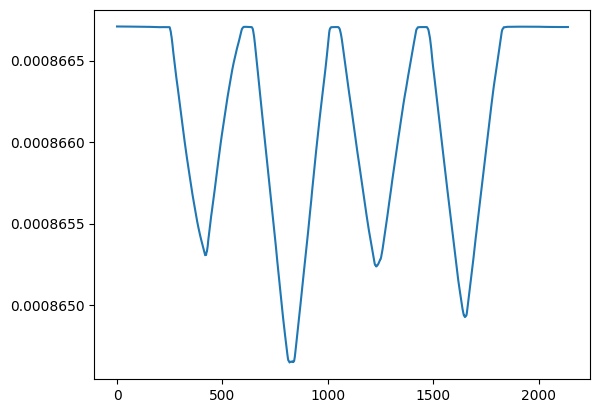

In [182]:
plt.plot(res_std)

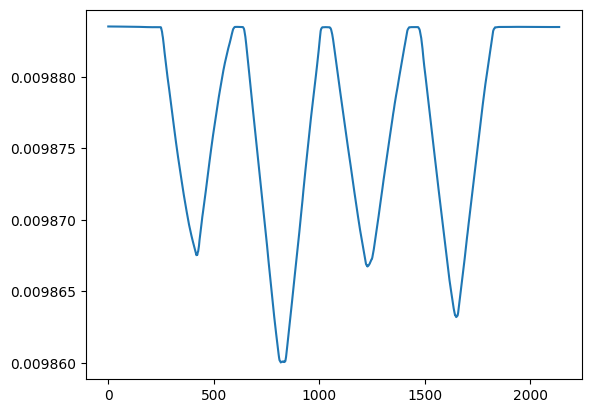

In [183]:
plt.plot(res_amax)